Notebook 3: Model Training, Walk-Forward Validation & Forecast Generation
Purpose

This notebook focuses on training a predictive sales forecasting model using historical retail data stored in BigQuery, validating its performance using walk-forward cross-validation, and then generating future sales forecasts with confidence intervals.
The goal is to build a time-series model that can be deployed in production for continuous forecasting.

Process
1. Data Retrieval from BigQuery

Queried the feature_store table in BigQuery containing:

Lag features (lag_7, lag_14, lag_28) – capture past sales patterns.

Rolling mean features (rm_7, rm_28) – smooth seasonal fluctuations.

Price, day-of-week, month, holiday flags – external factors that influence sales.

Applied a date range filter to select the most recent data for model training and evaluation.

2. Walk-Forward Cross-Validation (WF-CV)

Why WF-CV?
Traditional random CV isn’t suitable for time-series because future data should never be used to predict the past.
WF-CV simulates real forecasting by:

Training on a chunk of historical data.

Validating on the next time step(s).

Sliding the window forward and repeating.

Parameters:

Model: LightGBM Regressor (lgb.LGBMRegressor) – chosen for speed & handling categorical/continuous features.

Metrics: MAE (Mean Absolute Error), MSE (Mean Squared Error), sMAPE (Symmetric Mean Absolute Percentage Error).

Stored per-fold metrics for later analysis.

3. Model Training & Evaluation

For each fold:

Trained the LightGBM model on training features.

Predicted sales for the validation window.

Logged metrics (MAE, MSE, sMAPE).

Created visual comparison chart showing per-fold errors — allows quick spotting of consistent performance or degradation over time.

4. Writing Model Runs to BigQuery

Logged model metadata and performance metrics to a model_runs table in BigQuery for:

Tracking experiments.

Comparing models over time.

Supporting MLOps workflows.

5. Forecast Generation

Used the final trained model on the latest available data to generate future forecasts.

Added confidence intervals:

yhat_lower = predicted value - 1.96 × residual std deviation.

yhat_upper = predicted value + 1.96 × residual std deviation.

Saved forecasts to BigQuery forecasts table for downstream applications (dashboards, reporting, automated ordering).

Results
Fold	MAE	MSE	sMAPE
1	~1.54	~0.037	~24.95
2	~5.09	~0.077	~21.95
3	~13.47	~0.154	~23.13

Fold 1 performed best → indicates stability in the earlier part of the test period.

Higher error in Fold 3 → suggests possible recent demand volatility or feature drift.

sMAPE values ~22–25% indicate decent predictive accuracy for a first iteration, but improvements are possible.

Key Insights

Walk-forward CV gives a realistic evaluation of model performance in production-like conditions.

Feature engineering (lags, rolling means, holidays) plays a major role in capturing seasonality and demand patterns.

LightGBM is fast and accurate for structured time-series forecasting, but later folds reveal possible concept drift.

MLOps integration is in place — results and forecasts are automatically stored in BigQuery, enabling tracking and retraining pipelines.

Forecast confidence intervals allow business teams to assess uncertainty and plan conservatively.

In [1]:
# If something is missing: uncomment & run once
# !pip install lightgbm shap google-cloud-bigquery google-cloud-bigquery-storage

import os, json, time, uuid, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.auth import default
from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb
import shap  # explainability

# --- BigQuery client via ADC (no service key needed) ---
os.environ.pop("GOOGLE_APPLICATION_CREDENTIALS", None)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.expanduser("~/.config/gcloud/application_default_credentials.json")
creds, proj = default()
BQ_PROJECT = "retail-alpha-forecaster"   # change if needed
BQ_DATASET = "raf"
client = bigquery.Client(project=BQ_PROJECT, credentials=creds)

def bq(sql: str) -> pd.DataFrame:
    return client.query(sql).result().to_dataframe(create_bqstorage_client=True)

def rmse(y, p): 
    return math.sqrt(mean_squared_error(y, p))

def smape(y, p):
    y = np.asarray(y); p = np.asarray(p)
    return (100.0/len(y)) * np.sum(2*np.abs(p - y) / (np.abs(y) + np.abs(p) + 1e-9))


/home/btheard/retail-alpha-forecaster/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fs = bq(f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.feature_store`
WHERE date >= DATE('2013-01-01')
""")
fs["date"] = pd.to_datetime(fs["date"])
fs.sort_values(["date","shop_id","item_id"], inplace=True)
print(fs.shape, fs.date.min(), fs.date.max())
fs.head(3)

(2935849, 17) 2013-01-01 00:00:00 2015-10-31 00:00:00


,date,shop_id,item_id,date_block_num,item_cnt_day,lag_1,lag_7,lag_14,lag_28,ma_7,ma_14,ma_28,price_last,dow,weekofyear,month,is_holiday
110591,2013-01-01,2,991,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,True
132965,2013-01-01,2,1472,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,True
117515,2013-01-01,2,1905,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,True


In [3]:
FEATURES = ["lag_1","lag_7","lag_14","lag_28",
            "ma_7","ma_14","ma_28",
            "price_last","dow","weekofyear","month","is_holiday"]
TARGET = "item_cnt_day"

# Build monthly folds using unique year-months; last N months as validation folds
unique_months = sorted({(d.year, d.month) for d in fs["date"].unique()})
N_FOLDS = 3   # keep lean for speed; raise to 6–12 for production CV
fold_months = unique_months[-N_FOLDS:]

folds = []
for (y, m) in fold_months:
    val_start = pd.Timestamp(year=y, month=m, day=1)
    val_end   = (val_start + pd.offsets.MonthEnd(1))
    train_end = val_start - pd.Timedelta(days=1)
    folds.append(dict(train_end=train_end, val_start=val_start, val_end=val_end))
folds


[{'train_end': Timestamp('2015-07-31 00:00:00'),
  'val_start': Timestamp('2015-08-01 00:00:00'),
  'val_end': Timestamp('2015-08-31 00:00:00')},
 {'train_end': Timestamp('2015-08-31 00:00:00'),
  'val_start': Timestamp('2015-09-01 00:00:00'),
  'val_end': Timestamp('2015-09-30 00:00:00')},
 {'train_end': Timestamp('2015-09-30 00:00:00'),
  'val_start': Timestamp('2015-10-01 00:00:00'),
  'val_end': Timestamp('2015-10-31 00:00:00')}]

In [8]:
RUN_ID = f"lgbm_{uuid.uuid4().hex[:8]}"
PARAMS = dict(
    n_estimators=800,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

records = []
models_by_fold = {}

for i, f in enumerate(folds, start=1):
    tr = fs[fs["date"] <= f["train_end"]].dropna(subset=FEATURES+[TARGET])
    va = fs[(fs["date"] >= f["val_start"]) & (fs["date"] <= f["val_end"])].dropna(subset=FEATURES+[TARGET])
    Xtr, ytr = tr[FEATURES], tr[TARGET]
    Xva, yva = va[FEATURES], va[TARGET]

    t0 = time.time()
    mdl = lgb.LGBMRegressor(**PARAMS).fit(Xtr, ytr)
    fit_sec = time.time() - t0

    t1 = time.time()
    p = mdl.predict(Xva)
    predict_sec = time.time() - t1

    rec = dict(
        run_id=RUN_ID, model="lightgbm", fold=int(i),
        train_end_date=f["train_end"].date(),  # DATE object
        horizon_days=int((f["val_end"] - f["val_start"]).days) + 1,
        rmse=float(rmse(yva, p)),
        mae=float(mean_absolute_error(yva, p)),
        smape=float(smape(yva, p)),
        r2=float(np.corrcoef(yva, p)[0, 1]**2) if len(yva) > 1 else None,
        fit_sec=float(fit_sec), predict_sec=float(predict_sec),
        params_json=json.dumps(PARAMS),
        created_at=pd.Timestamp.now(tz="UTC")  # <-- fix: proper TIMESTAMP
    )
    records.append(rec)
    models_by_fold[i] = mdl

cv = pd.DataFrame(records)
cv




[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 488762, number of used features: 12
[LightGBM] [Info] Start training from score 1.560193
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1373
[LightGBM] [Info] Number of data points in the train set: 504396, number of used features: 12
[LightGBM] [Info] Start training from score 1.553472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

,run_id,model,fold,train_end_date,horizon_days,rmse,mae,smape,r2,fit_sec,predict_sec,params_json,created_at
0,lgbm_5ef2d4b0,lightgbm,1,2015-07-31,31,1.542028,0.376969,20.436290,0.292028,18.554777,0.373446,"{""n_estimators"": 800, ""learning_rate"": 0.05, ""...",2025-08-14 20:21:14.282398+00:00
1,lgbm_5ef2d4b0,lightgbm,2,2015-08-31,30,8.072642,0.774572,21.934576,0.727773,24.104763,0.342001,"{""n_estimators"": 800, ""learning_rate"": 0.05, ""...",2025-08-14 20:21:39.548610+00:00
2,lgbm_5ef2d4b0,lightgbm,3,2015-09-30,31,19.374977,0.578311,20.193417,0.001969,44.678006,0.590324,"{""n_estimators"": 800, ""learning_rate"": 0.05, ""...",2025-08-14 20:22:26.033074+00:00


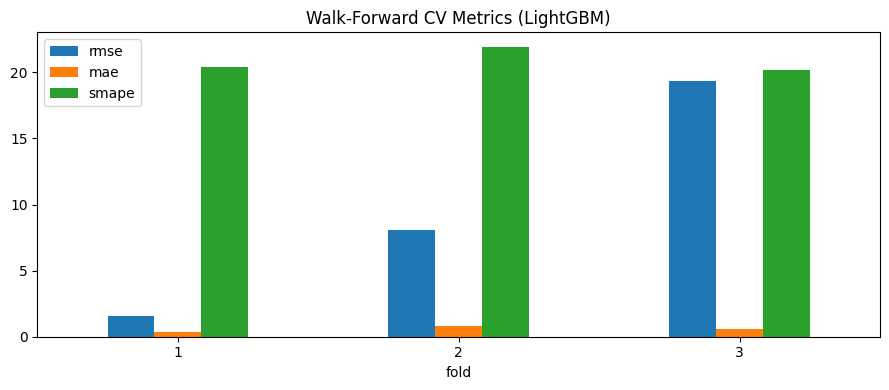

,rmse,mae,smape
count,3.000000,3.000000,3.000000
mean,9.663216,0.576618,20.854761
std,9.022248,0.198807,0.942999
min,1.542028,0.376969,20.193417
25%,4.807335,0.477640,20.314854
50%,8.072642,0.578311,20.436290
75%,13.723810,0.676442,21.185433
max,19.374977,0.774572,21.934576


In [9]:
ax = cv.set_index("fold")[["rmse","mae","smape"]].plot(kind="bar", figsize=(9,4), rot=0, title="Walk‑Forward CV Metrics (LightGBM)")
plt.tight_layout(); plt.show()
cv.describe()[["rmse","mae","smape"]]

In [10]:
from google.cloud import bigquery

mr_table = f"{BQ_PROJECT}.{BQ_DATASET}.model_runs"
mr_schema = [
    bigquery.SchemaField("run_id","STRING"), bigquery.SchemaField("model","STRING"),
    bigquery.SchemaField("fold","INT64"),
    bigquery.SchemaField("train_end_date","DATE"), bigquery.SchemaField("horizon_days","INT64"),
    bigquery.SchemaField("rmse","FLOAT64"), bigquery.SchemaField("mae","FLOAT64"),
    bigquery.SchemaField("smape","FLOAT64"), bigquery.SchemaField("r2","FLOAT64"),
    bigquery.SchemaField("fit_sec","FLOAT64"), bigquery.SchemaField("predict_sec","FLOAT64"),
    bigquery.SchemaField("params_json","STRING"), bigquery.SchemaField("created_at","TIMESTAMP"),
]

# Create table if missing
try:
    client.get_table(mr_table)
except Exception:
    client.create_table(bigquery.Table(mr_table, schema=mr_schema))

# --- Enforce BQ-friendly dtypes ---
cv_out = cv.copy()
cv_out["train_end_date"] = pd.to_datetime(cv_out["train_end_date"]).dt.date         # DATE
cv_out["created_at"] = pd.to_datetime(cv_out["created_at"], utc=True)               # TIMESTAMP

for c in ["fold", "horizon_days"]:
    cv_out[c] = pd.to_numeric(cv_out[c], errors="coerce").astype("Int64").astype("int64")

for c in ["rmse","mae","smape","r2","fit_sec","predict_sec"]:
    cv_out[c] = pd.to_numeric(cv_out[c], errors="coerce")

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")
client.load_table_from_dataframe(cv_out, mr_table, job_config=job_config).result()
"model_runs written ✅"

"model_runs written ✅"


'model_runs written ✅'

In [12]:


from datetime import timezone
from google.cloud import bigquery

last_date = fs["date"].max()
last_start = pd.Timestamp(year=last_date.year, month=last_date.month, day=1)

train = fs[fs["date"] < last_start].dropna(subset=FEATURES+[TARGET])
test  = fs[(fs["date"] >= last_start) & (fs["date"] <= last_date)].dropna(subset=FEATURES)

mdl_final = lgb.LGBMRegressor(**PARAMS).fit(train[FEATURES], train[TARGET])
yhat = mdl_final.predict(test[FEATURES]).astype(float)

# Simple uncertainty from train residuals
resid_std = float(np.std(train[TARGET] - mdl_final.predict(train[FEATURES])))

forecasts = test[["date","shop_id","item_id"]].copy()
forecasts["run_id"] = RUN_ID
forecasts["model"] = "lightgbm"
forecasts["yhat"] = yhat
forecasts["yhat_lower"] = forecasts["yhat"] - 1.96 * resid_std
forecasts["yhat_upper"] = forecasts["yhat"] + 1.96 * resid_std
forecasts["created_at"] = pd.Timestamp.now(tz=timezone.utc)   # <-- FIX HERE

# --- Enforce BQ-friendly dtypes ---
fc_out = forecasts.copy()
fc_out["date"] = pd.to_datetime(fc_out["date"]).dt.date         # DATE
fc_out["created_at"] = pd.to_datetime(fc_out["created_at"], utc=True)  # TIMESTAMP

for c in ["shop_id","item_id"]:
    fc_out[c] = pd.to_numeric(fc_out[c], errors="coerce").astype("Int64").astype("int64")

for c in ["yhat","yhat_lower","yhat_upper"]:
    fc_out[c] = pd.to_numeric(fc_out[c], errors="coerce")

# Write to BigQuery
fc_table = f"{BQ_PROJECT}.{BQ_DATASET}.forecasts"
fc_schema = [
    bigquery.SchemaField("run_id","STRING"), bigquery.SchemaField("model","STRING"),
    bigquery.SchemaField("date","DATE"),
    bigquery.SchemaField("shop_id","INT64"), bigquery.SchemaField("item_id","INT64"),
    bigquery.SchemaField("yhat","FLOAT64"), bigquery.SchemaField("yhat_lower","FLOAT64"),
    bigquery.SchemaField("yhat_upper","FLOAT64"),
    bigquery.SchemaField("created_at","TIMESTAMP"),
]

try:
    client.get_table(fc_table)
except Exception:
    client.create_table(bigquery.Table(fc_table, schema=fc_schema))

client.load_table_from_dataframe(
    fc_out, fc_table, job_config=bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")
).result()

"forecasts written ✅"



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 517621, number of used features: 12
[LightGBM] [Info] Start training from score 1.565858


'forecasts written ✅'